<a href="https://colab.research.google.com/github/KadaliSana/LLMs-Colab/blob/main/Wizard-VicunaLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain huggingface_hub sentence_transformers 
!pip install -q accelerate bitsandbytes safetensors
!pip uninstall transformers -y
!pip install transformers[agents]
!pip install git+https://github.com/huggingface/transformers.git
!git lfs install
!git clone https://huggingface.co/TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ ./models/TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ
!git clone https://github.com/oobabooga/GPTQ-for-LLaMa.git -b cuda
# !cp ./GPTQ-for-LLaMa/setup_cuda.py ./GPTQ-for-LLaMa/setup.py
# !cd GPTQ-for-LLaMa && python setup_cuda.py install
!cd GPTQ-for-LLaMa && python3 setup_cuda.py bdist_wheel -d .
!pip install ./GPTQ-for-LLaMa/*.whl
!pip install xformers
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.0/990.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00

In case GPU memory is less than required to be used then change the model from 13B to 7B by replacing the 13 by 7 which uses only 6gb of vram.




In [ ]:
from pathlib import Path

import sys
sys.path.insert(0, str(Path("/content/GPTQ-for-LLaMa")))

import os
import glob
import site 
import torch
import logging
import accelerate
import inspect

import numpy as np
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, HuggingFaceHub, LLMChain

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    AutoModelForSeq2SeqLM,
    BitsAndBytesConfig,
    LlamaTokenizer,
    AutoConfig, 
    AutoModelForCausalLM
)
try:
    from modelutils import find_layers
except ImportError:
    from utils import find_layers


try:
    from quant import make_quant
    is_triton = False
except ImportError:
    import quant
    is_triton = True
GPTQ_MODEL_DIR = "/content/models/TheBloke"
MODEL_NAME = "Wizard-Vicuna-13B-Uncensored-GPTQ"

def find_quantized_model_file(model_name, args):
    if args.checkpoint:
        return Path(args.checkpoint)

    path_to_model = Path(f'{args.model_dir}/{model_name}')
    print(f"Path to Model: {path_to_model}")
    pt_path = None
    priority_name_list = [
        Path(f'{args.model_dir}/{model_name}{hyphen}{args.wbits}bit{group}{ext}')
        for group in ([f'-{args.groupsize}g', ''] if args.groupsize > 0 else [''])
        for ext in ['.safetensors', '.pt']
        for hyphen in ['-', f'/{model_name}-', '/']
    ]
    for path in priority_name_list:
        if path.exists():
            pt_path = path
            break

    # If the model hasn't been found with a well-behaved name, pick the last .pt
    # or the last .safetensors found in its folder as a last resort
    if not pt_path:
        found_pts = list(path_to_model.glob("*.pt"))
        found_safetensors = list(path_to_model.glob("*.safetensors"))
        pt_path = None

        if len(found_pts) > 0:
            if len(found_pts) > 1:
                logging.warning('More than one .pt model has been found. The last one will be selected. It could be wrong.')

            pt_path = found_pts[-1]
        elif len(found_safetensors) > 0:
            if len(found_pts) > 1:
                logging.warning('More than one .safetensors model has been found. The last one will be selected. It could be wrong.')

            pt_path = found_safetensors[-1]

    return pt_path

def _load_quant(model, checkpoint, wbits, groupsize=-1, faster_kernel=False, eval=False, exclude_layers=['lm_head'], kernel_switch_threshold=128):
    def noop(*args, **kwargs):
        pass

    config = AutoConfig.from_pretrained(model, trust_remote_code=True)
    logging.info(f"Model Config: {config}")
    
    torch.nn.init.kaiming_uniform_ = noop
    torch.nn.init.uniform_ = noop
    torch.nn.init.normal_ = noop

    torch.set_default_dtype(torch.half)
    transformers.modeling_utils._init_weights = False
    torch.set_default_dtype(torch.half)
    model = AutoModelForCausalLM.from_config(config, trust_remote_code=True)
    torch.set_default_dtype(torch.float)
    
    if eval:
        model = model.eval()

    layers = find_layers(model)
    for name in exclude_layers:
        if name in layers:
            del layers[name]

    if not is_triton:
        gptq_args = inspect.getfullargspec(make_quant).args
        make_quant_kwargs = {
                'module': model,
                'names': layers,
                'bits': wbits,
            }
        if 'groupsize' in gptq_args:
            make_quant_kwargs['groupsize'] = groupsize
        if 'faster' in gptq_args:
            make_quant_kwargs['faster'] = faster_kernel
        if 'kernel_switch_threshold' in gptq_args:
            make_quant_kwargs['kernel_switch_threshold'] = kernel_switch_threshold
        
        make_quant(**make_quant_kwargs)
    else:
        logging.exception("Triton not supported!")

    del layers

    if checkpoint.endswith('.safetensors'):
        from safetensors.torch import load_file as safe_load
        model.load_state_dict(safe_load(checkpoint), strict=False)
    else:
        model.load_state_dict(torch.load(checkpoint), strict=False)

    model.seqlen = 2048
    return model

def load_quantized_model(model_name, args, load_tokenizer=True):
    tokenizer = None
    path_to_model = Path(f'{args.model_dir}/{model_name}')
    pt_path = find_quantized_model_file(model_name, args)
    if not pt_path:
        print(pt_path)
        logging.error("Could not find the quantized model in .pt or .safetensors format, exiting...")
        return
    else:
        logging.info(f"Found the following quantized model: {pt_path}")
    
    threshold = args.threshold if args.threshold else 128

    model = _load_quant(
        str(path_to_model), 
        str(pt_path), 
        args.wbits, 
        args.groupsize, 
        kernel_switch_threshold=threshold
    )

    model = model.to(torch.device("cuda:0"))

    if load_tokenizer:
        tokenizer = LlamaTokenizer.from_pretrained(
            Path(f"{args.model_dir}/{model_name}/"), 
            clean_up_tokenization_spaces=True
        )

        try:
            tokenizer.eos_token_id = 2
            tokenizer.bos_token_id = 1
            tokenizer.pad_token_id = 0
        except:
            pass

    return model, tokenizer

class AttributeDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
     
     

In [ ]:
args = {
    "wbits": 4,
    "groupsize": 128,
    "model_type": "llama",
    "model_dir": GPTQ_MODEL_DIR,
}

model, tokenizer = load_quantized_model(MODEL_NAME, args=AttributeDict(args))

max_memory = {
    0: "15360MiB",
    'cpu': "12GiB"
}
     
device_map = accelerate.infer_auto_device_map(
    model, 
    max_memory=max_memory, 
    no_split_module_classes=["LlamaDecoderLayer"]
)
model = accelerate.dispatch_model(
    model, 
    device_map=device_map, 
    offload_buffers=True
)

model.get_memory_footprint() / (1024 * 1024)

llm_pipeline = pipeline(
    "text-generation",
    model=model, 
    tokenizer=tokenizer, 
    max_length=512,
    device_map=device_map
)

Path to Model: /content/models/TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ


==Explanation from the agent==



==Code generated by the agent==
image = image_generator(prompt="Draw a picture of yourself")


==Result==


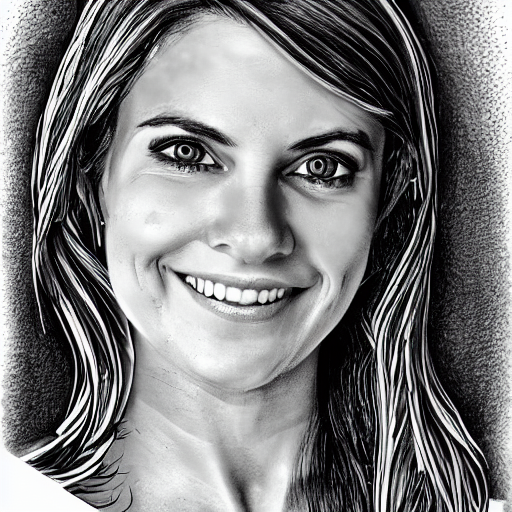

In [ ]:
from transformers.tools import agents
agent = agents.LocalAgent(model, tokenizer)
template = ''' Below are a series of dialogues between various people and an AI assistant specialized in coding. The AI assistant tries to be helpful, polite, honest, and humble-but-knowledgeable.

The job of the AI assistant is to come up with a series of simple commands in Python that will perform the task the human wants to perform.
To help with that, the AI assistant has access to a set of tools. Each tool is a Python function and has a description explaining the task it performs, the inputs it expects and the outputs it returns.
The AI assistant should first explain the tools it will use to perform the task and for what reason, then write the code in Python.
Each instruction in Python should be a simple assignment. The AI assistant can print intermediate results if it makes sense to do so.

Tools:
<<all_tools>>

=====

Human: Answer the question in the variable `question` about the image stored in the variable `image`.

Assistant: I will use the tool `image_qa` to answer the question on the input image.

```py
answer = image_qa(text=question, image=image)
print(f"The answer is {answer}")
```

Human: I tried this code, it worked but didn't give me a good result. The question is in French

Assistant: In this case, the question needs to be translated first. I will use the tool `translator` to do this.

```py
translated_question = translator(question=question, src_lang="French", tgt_lang="English")
print(f"The translated question is {translated_question}.")
answer = image_qa(text=translated_question, image=image)
print(f"The answer is {answer}")
```

=====

Human: Identify the oldest person in the `document`.

Assistant: I will use the tool `document_qa` to find the oldest person in the document.

```py
answer = document_qa(document, question="What is the oldest person?")
print(f"The answer is {answer}.")
```

Human: Can you generate an image with the result?

Assistant: I will use the tool `image_generator` to do that.

```py
image = image_generator(answer)
```

=====

Human: Summarize the text given in the variable `text` and read it out loud.

Assistant: I will use the tool `summarizer` to create a summary of the input text, then the tool `text_reader` to read it out loud.

```py
summarized_text = summarizer(text)
print(f"Summary: {summarized_text}")
audio_summary = text_reader(text=summary)
```

Human: I got the following error: "The variable `summary` is not defined."

Assistant: My bad! Let's try this code instead.

```py
summarized_text = summarizer(text)
print(f"Summary: {summarized_text}")
audio_summary = text_reader(text=summarized_text)
```

Human: It worked! Can you translate the summary in German?

Assistant: I will use the tool `translator` to translate the text in German.

```py
translated_summary = translator(summarized_text, src_lang="English", tgt_lang="German")
```

====
 '''
agent.chat("Draw a picture of yourself",remote= True,run_prompt_template=template )

In [ ]:
from langchain.agents import Tool
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.utilities import SerpAPIWrapper
from langchain.agents import initialize_agent
import serpapi

# Set the SerpAPI API key
%env SERPAPI_API_KEY = "95242b564735e5e6460496984ce1599a5cd2019f1f6ac52bed4e23287c54583e"

llm=local_llm
search = SerpAPIWrapper()
tools = [
    Tool(
        name = "Current Search",
        func=search.run,
        description="useful for when you need to answer questions about current events or the current state of the world"
    ),
]
memory = ConversationBufferMemory(memory_key="chat_history")
agent_chain = initialize_agent(tools, llm, agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION, verbose=True, memory=memory)

==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image according to the prompt.


==Code generated by the agent==
image = image_generator(prompt="Draw me a picture of rivers and lakes.")
```</s>


==Result==


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 13>:13                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tools/agents.py:343 in run                  │
│                                                                                                  │
│   340 │   │   self.log(f"\n\n==Code generated by the agent==\n{code}")                           │
│   341 │   │   if not return_code:                                                                │
│   342 │   │   │   self.log("\n\n==Result==")                                                     │
│ ❱ 343 │   │   │   self.cached_tools = resolve_tools(code, self.toolbox, remote=remote, cached_   │
│   344 │   │   │   return evaluate(code, self.cached_tools, state=kwargs.copy())                  │
│   345 │   │   else:                                                                              │
│   346 │   │   │   tool_code = get_tool_creation_code(code, self.toolbox, remote=remote)          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tools/agents.py:135 in resolve_tools        │
│                                                                                                  │
│   132 │   │   else:                                                                              │
│   133 │   │   │   task_or_repo_id = tool.task if tool.repo_id is None else tool.repo_id          │
│   134 │   │   │   _remote = remote and supports_remote(task_or_repo_id)                          │
│ ❱ 135 │   │   │   resolved_tools[name] = load_tool(task_or_repo_id, remote=_remote)              │
│   136 │                                                                                          │
│   137 │   return resolved_tools                                                                  │
│   138                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/tools/base.py:680 in load_tool              │
│                                                                                                  │
│   677 │   │   else:                                                                              │
│   678 │   │   │   return tool_class(model_repo_id, token=token, **kwargs)                        │
│   679 │   else:                                                                                  │
│ ❱ 680 │   │   return Tool.from_hub(task_or_repo_id, model_repo_id=model_repo_id, token=token,    │
│   681                                                                                            │
│   682                                                      

In [ ]:
agent_chain.run(input="hi, i am bob")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? No
AI: Hi Bob! How are you doing today?

> Finished chain.


'Hi Bob! How are you doing today?'

In [ ]:
agent_chain.run(input="what's my name?")



> Entering new AgentExecutor chain...

Thought: Do I need to use a tool? Yes
Action: Current Search
Action Input: what's my name?

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/langchain/chains/base.py:259 in run                      │
│                                                                                                  │
│   256 │   │   │   return self(args[0], callbacks=callbacks)[self.output_keys[0]]                 │
│   257 │   │                                                                                      │
│   258 │   │   if kwargs and not args:                                                            │
│ ❱ 259 │   │   │   return self(kwargs, callbacks=callbacks)[self.output_keys[0]]                  │
│   260 │   │                                                                                      │
│   261 │   │   if not kwargs and not args:                                                        │
│   262 │   │   │   raise ValueError(                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/langchain/chains/base.py:145 in __call__                 │
│                                                                                                  │
│   142 │   │   │   )                                                                              │
│   143 │   │   except (KeyboardInterrupt, Exception) as e:                                        │
│   144 │   │   │   run_manager.on_chain_error(e)                                                  │
│ ❱ 145 │   │   │   raise e                                                                        │
│   146 │   │   run_manager.on_chain_end(outputs)                                                  │
│   147 │   │   final_outputs: Dict[str, Any] = self.prep_outputs(                                 │
│   148 │   │   │   inputs, outputs, return_only_outputs                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/langchain/chains/base.py:139 in __call__                 │
│                                                                                                  │
│   136 │   │   )                                                                                  │
│   137 │   │   try:                                                                               │
│   138 │   │   │   outputs = (                                                                    │
│ ❱ 139 │   │   │   │   self._call(inputs, run_manager=run_manager)                                │
│   140 │   │   │   │   if new_arg_supported                                                       │
│   141 │   │   │   │   else self._call(inputs)                                                    │
│   142 │   │   │   )                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/langchain/agents/agent.py:953 in _call                   │
│                                                                                                  │
│    950 │   │   start_time = time.time()                                                          │
│    951 │   │   # We now enter the agent loop (until it returns something).                       │
│    952 │   │   while self._should_continue(iterations, time_elapsed):                            │
│ ❱  953 │   │   │   next_step_output = self._take_next_step(                                      │
│    954 │   │   │   │   name_to_tool_map,                   

In [ ]:
from flask_ngrok import run_with_ngrok
import flask

app = flask.Flask(__name__)

@app.route('/<text>', methods= ['GET'])
def alpaca_talk(text):
    text = '''Below is an instruction that describes a task. Write a response that appropriately completes the request.
     ### Instruction:''' + text +'''### Response:'''
    output = text.replace("%20"," ")
    print (output)
    inputs = tokenizer(
        output,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"].cuda()

    generation_config = GenerationConfig(
        temperature=0.6,
        top_p=0.95,
        repetition_penalty=1.2,
    )
    print("Generating...")
    generation_output = model.generate(
        input_ids=input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=256,
    )
    for s in generation_output.sequences:
        response = (tokenizer.decode(s))
        print (response)
        return response


input_text ='''
What are Alpacas and how are they different to Lamas?
'''

alpaca_talk(input_text)

run_with_ngrok(app)

if __name__ == '__main__':
    app.run()  

Below is an instruction that describes a task. Write a response that appropriately completes the request.
     ### Instruction:
What are Alpacas and how are they different to Lamas?
### Response:
Generating...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 41>:41                                                                            │
│ in alpaca_talk:24                                                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:739 in generate                       │
│                                                                                                  │
│    736 │   │   self.base_model.prepare_inputs_for_generation = self.prepare_inputs_for_generati  │
│    737 │   │   try:                                                                              │
│    738 │   │   │   if not isinstance(peft_config, PromptLearningConfig):                         │
│ ❱  739 │   │   │   │   outputs = self.base_model.generate(**kwargs)                              │
│    740 │   │   │   else:                                                                         │
│    741 │   │   │   │   if "input_ids" not in kwargs:                                             │
│    742 │   │   │   │   │   raise ValueError("input_ids must be provided for Peft model generati  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1406 in generate        │
│                                                                                                  │
│   1403 │   │   │   │   )                                                                         │
│   1404 │   │   │                                                                                 │
│   1405 │   │   │   # 11. run greedy search                                                       │
│ ❱ 1406 │   │   │   return self.greedy_search(                                                    │
│   1407 │   │   │   │   input_ids,                                                                │
│   1408 │   │   │   │   logits_processor=logits_processor,                                        │
│   1409 │   │   │   │   stopping_criteria=stopping_criteria,                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2201 in greedy_search   │
│                                                                                                  │
│   2198 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2199 │   │   │                                                                                 │
│   2200 │   │   │   # forward pass to get next token                                              │
│ ❱ 2201 │   │   │   outputs = self(                         

### Instruction:
What are Alpacas and how are they different to Lamas?

### Response:
Alpaca's are small, domesticated animals native to South America while Lama's are large wild animals from Central Asia. 
The main difference between these two species is their size; alpacas grow up to about three feet tall (1 meter) whereas lamas can reach heights of over six feet (2 meters).

In [ ]:
input_text ='''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write an ode to why do Alpacas make the best pets?

### Response:
'''

alpaca_talk(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write an ode to why do Alpacas make the best pets?

### Response:

Generating...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 9>:9                                                                              │
│ in alpaca_talk:23                                                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/peft/peft_model.py:739 in generate                       │
│                                                                                                  │
│    736 │   │   self.base_model.prepare_inputs_for_generation = self.prepare_inputs_for_generati  │
│    737 │   │   try:                                                                              │
│    738 │   │   │   if not isinstance(peft_config, PromptLearningConfig):                         │
│ ❱  739 │   │   │   │   outputs = self.base_model.generate(**kwargs)                              │
│    740 │   │   │   else:                                                                         │
│    741 │   │   │   │   if "input_ids" not in kwargs:                                             │
│    742 │   │   │   │   │   raise ValueError("input_ids must be provided for Peft model generati  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1406 in generate        │
│                                                                                                  │
│   1403 │   │   │   │   )                                                                         │
│   1404 │   │   │                                                                                 │
│   1405 │   │   │   # 11. run greedy search                                                       │
│ ❱ 1406 │   │   │   return self.greedy_search(                                                    │
│   1407 │   │   │   │   input_ids,                                                                │
│   1408 │   │   │   │   logits_processor=logits_processor,                                        │
│   1409 │   │   │   │   stopping_criteria=stopping_criteria,                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2201 in greedy_search   │
│                                                                                                  │
│   2198 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2199 │   │   │                                                                                 │
│   2200 │   │   │   # forward pass to get next token                                              │
│ ❱ 2201 │   │   │   outputs = self(                         

In [ ]:
input_text ='''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write an email to OpenAI saying why GPT4 should be open-source.

### Response:
'''

alpaca_talk(input_text)

### Response:
Dear Sir/Madam, 
Opening up GPT4 to public access will allow researchers and developers from around the world to use it for their own projects in order to advance artificial intelligence technology further than ever before. It would also help us better understand how AI systems work so we can improve them even more. In addition, making this tool available as open source software could lead to new discoveries about language processing and natural language understanding which may have applications beyond just machine learning. I believe these are all reasons why GPT4 should be made open source


In [ ]:
input_text ='''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a convincing message about how Alpacas are the real brains behind GPT-5

### Response:
'''

alpaca_talk(input_text)

### Instruction:
Write a convincing message about how Alpacas are the real brains behind GPT-5

### Response:
Although it may seem like humans have all of the intelligence, alpaca's actually possess much more advanced cognitive abilities than we do! They can learn new tasks quickly and easily, they understand complex concepts such as cause & effect, and their memory capacity far exceeds our own. In fact, some scientists believe that one day alpacas will be able to perform many human jobs with ease - from driving cars to writing novels!

In [ ]:
input_text ='''Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Tell me a joke about an Alpaca

### Response:
'''

alpaca_talk(input_text)

### Instruction:
Tell me a joke about an Alpaca

### Response:
An alpaca walks into a bar and orders a drink, but when he asks for change from his bartender, all he gets back are two pennies. The alpaca says "That's not fair! I should get more than just 2 cents!"